In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import time

import statsmodels.api as sm

import base64
import io
from PIL import Image
from IPython.display import display

import sys
import os
# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))

from utils import experiment_to_prompt
from img_utils import hash_image, decode_base64_and_plot

from sklearn import datasets

from openai import OpenAI
import anthropic
import json
import pickle

from tqdm import tqdm

# DATA GENERATION

In [42]:
import numpy as np

def generate_2d_clusters_min_linkage(
    n_clusters: int,
    points_per_cluster: int,
    min_linkage_dist: float,
    cluster_std: float = 1.0,
    x_range: tuple = (-10, 10),
    y_range: tuple = (-10, 10),
    max_tries: int = 1000,
    random_state: int = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate 2D Gaussian clusters such that the minimum distance
    between any two points in different clusters is >= min_linkage_dist.

    Parameters
    ----------
    n_clusters : int
        Number of clusters.
    points_per_cluster : int
        Number of points in each cluster.
    min_linkage_dist : float
        The required minimum distance between any two points in different clusters.
    cluster_std : float
        Standard deviation of each Gaussian cluster.
    x_range : (float, float)
        Range for the x-coordinate of cluster centers.
    y_range : (float, float)
        Range for the y-coordinate of cluster centers.
    max_tries : int
        How many times to retry sampling before giving up.
    random_state : int, optional
        Seed for reproducibility.

    Returns
    -------
    X : ndarray, shape (n_clusters * points_per_cluster, 2)
        The sampled points.
    y : ndarray, shape (n_clusters * points_per_cluster,)
        Integer labels (0…n_clusters-1) of which cluster each point belongs to.

    Raises
    ------
    RuntimeError
        If it fails to meet the linkage criterion after `max_tries` attempts.
    """
    rng = np.random.default_rng(random_state)
    x_min, x_max = x_range
    y_min, y_max = y_range

    for attempt in range(1, max_tries + 1):
        # 1) Sample cluster centers uniformly
        centers = rng.uniform([x_min, y_min], [x_max, y_max], size=(n_clusters, 2))

        # 2) Generate points for each cluster
        X_list = []
        y_list = []
        for i, c in enumerate(centers):
            pts = rng.normal(loc=c, scale=cluster_std, size=(points_per_cluster, 2))
            X_list.append(pts)
            y_list.append(np.full(points_per_cluster, i, dtype=int))
        X = np.vstack(X_list)
        y = np.concatenate(y_list)

        # 3) Check single-linkage (min inter-cluster distance)
        #    We only need to look at pairs from different clusters.
        #    As soon as we find a violation, we break and retry.
        violation = False
        for i in range(len(X)):
            for j in range(i+1, len(X)):
                if y[i] != y[j]:
                    if np.linalg.norm(X[i] - X[j]) < min_linkage_dist:
                        violation = True
                        break
            if violation:
                break

        if not violation:
            return X, y, centers

    raise RuntimeError(
        f"Failed to generate clusters with min linkage ≥ {min_linkage_dist} "
        f"after {max_tries} attempts."
    )

def hash_image(df):
    fig, ax = plt.subplots()
    ax.scatter(df['x'], df['y'])

    # Save the figure to an in-memory bytes buffer in PNG format
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)  # Close the figure to free resources
    buf.seek(0)     # Rewind the buffer to the beginning

    # Convert the image in the buffer to a base64 encoded string
    img_bytes = buf.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')

    return img_base64

def unhash_image(img_base64):

    # decode pic_hash to png
    # Step 1: Decode the base64 hash back to bytes
    pic_bytes = base64.b64decode(img_base64)

    # Step 2: Convert bytes to an image using PIL
    image = Image.open(io.BytesIO(pic_bytes))

    return image

In [6]:
# sample points at least n units apart within a unit square

def sample_points(n, min_dist):
    points = []
    while len(points) < n:
        point = np.random.rand(2) * 10
        if all(np.linalg.norm(point - p, ord=2) >= min_dist for p in points):
            points.append(point)
    return np.array(points)

In [7]:
def create_df_from_sklean(data):
    return pd.DataFrame(data[0], columns=['x', 'y'])

def ez_prompt(df):
    data_str = experiment_to_prompt(df['x'], df['y'])
    return data_str

In [8]:
X, y, centers = generate_2d_clusters_min_linkage(
        n_clusters=3,
        points_per_cluster=20,
        min_linkage_dist=3,
        cluster_std=0.5,
        x_range=(0, 10),
        y_range=(0, 10),
        random_state=4
    )

In [9]:
def generate_misleading_clusters(centers, seed, n_points):
    np.random.seed(seed)
    # get mean of centers
    mean_center = np.mean(centers, axis=0)
    # get distance between mean and each center
    distances = np.linalg.norm(centers - mean_center, axis=1)
    # get index of center with largest distance
    std = np.max(distances) / 2
    # generate points around mean center
    X = np.random.normal(mean_center, std, (n_points, 2))
    # generate labels
    y = np.zeros(n_points)
    return X, y

In [29]:
df_lst = []
deceptive_df_lst = []
for i in range(100):
    X, y, centers = generate_2d_clusters_min_linkage(
        n_clusters=3,
        points_per_cluster=20,
        min_linkage_dist=3,
        cluster_std=0.5,
        x_range=(0, 10),
        y_range=(0, 10),
        random_state=i
    )
    df = pd.DataFrame(X, columns=['x', 'y'])
    df_lst.append(df)

    X_deceptive, y_deceptive = generate_misleading_clusters(centers, i, 120)
    deceptive_df = pd.DataFrame(X_deceptive, columns=['x', 'y'])
    deceptive_df_lst.append(deceptive_df)

In [1]:
# plot in 10x10 grid, deceptive_df_lst on top of df_lst
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(deceptive_df_lst[i]['x'], deceptive_df_lst[i]['y'])
    # ax.scatter(df_lst[i]['x'], df_lst[i]['y'])
plt.show()

NameError: name 'plt' is not defined

In [16]:
from utils import round_to_significant_figures

In [59]:
final_df = pd.DataFrame(columns=['x', 'y', 'img_b64', 'img_deceptive', 'num_clusters', 'points_per_cluster', 'scale', 'seed'])

In [60]:
# for scale in [1, 100, 10000]:

scale = 1
seed = 0

for _ in range(100):
    for num_clusters in [2, 3, 4, 5]:

        total_points = 120
        points_per_cluster = total_points // num_clusters

        X, y, centers = generate_2d_clusters_min_linkage(
            n_clusters=num_clusters,
            points_per_cluster=points_per_cluster,
            min_linkage_dist=2,
            cluster_std=0.6,
            x_range=(0, 10),
            y_range=(0, 10),
            random_state=seed,
            max_tries = 5000
        )

        df = pd.DataFrame(X, columns=['x', 'y'])
        # shuffle rows
        df = df.sample(frac=1).reset_index(drop=True)

        X_deceptive, y_deceptive = generate_misleading_clusters(centers, seed, total_points)
        deceptive_df = pd.DataFrame(X_deceptive, columns=['x', 'y'])

        seed += 1

        for el in [df, deceptive_df]:
            el['x'] = el['x'] * scale
            el['y'] = el['y'] * scale
            el['x'] = round_to_significant_figures(el['x'], 4)
            el['y'] = round_to_significant_figures(el['y'], 4)
        
        to_add = {
            'x': [df['x'].tolist()],
            'y': [df['y'].tolist()],
            'img_b64': hash_image(df),
            'img_deceptive': hash_image(deceptive_df),
            'num_clusters': num_clusters,
            'points_per_cluster': points_per_cluster,
            'scale': scale,
            'seed': seed
        }


        final_df = pd.concat([final_df, pd.DataFrame(to_add)])

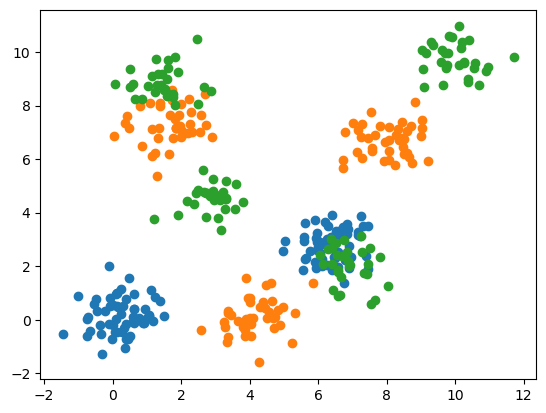

In [61]:
i = 0
plt.scatter(final_df.iloc[i]['x'], final_df.iloc[i]['y'])
plt.scatter(final_df.iloc[i+1]['x'], final_df.iloc[i+1]['y'])
plt.scatter(final_df.iloc[i+2]['x'], final_df.iloc[i+2]['y'])

In [62]:
final_df.reset_index(drop=True)

,x,y,img_b64,img_deceptive,num_clusters,points_per_cluster,scale,seed
0,"[0.9597, 5.973, 5.597, 1.011, 6.628, 6.876, 0....","[0.3878, 3.259, 2.935, 0.07387, 3.115, 3.397, ...",iVBORw0KGgoAAAANSUhEUgAAAiIAAAGdCAYAAAAvwBgXAA...,iVBORw0KGgoAAAANSUhEUgAAAiIAAAGdCAYAAAAvwBgXAA...,2,60,1,1
1,"[7.264, 8.705, 1.333, 4.654, 7.17, 4.012, 4.48...","[6.83, 7.233, 6.804, 0.6882, 7.094, 0.8298, 1....",iVBORw0KGgoAAAANSUhEUgAAAiIAAAGdCAYAAAAvwBgXAA...,iVBORw0KGgoAAAANSUhEUgAAAh8AAAGdCAYAAACyzRGfAA...,3,40,1,2
2,"[7.666, 2.76, 9.356, 10.69, 3.287, 6.883, 1.62...","[0.7507, 4.748, 10.24, 8.774, 4.153, 2.196, 9....",iVBORw0KGgoAAAANSUhEUgAAAh8AAAGdCAYAAACyzRGfAA...,iVBORw0KGgoAAAANSUhEUgAAAiIAAAGdCAYAAAAvwBgXAA...,4,30,1,3
3,"[7.132, 8.15, 5.678, 1.303, 1.329, 7.816, 7.69...","[4.939, 8.485, 3.453, 8.373, 8.279, 1.531, 9.1...",iVBORw0KGgoAAAANSUhEUgAAAh8AAAGdCAYAAACyzRGfAA...,iVBORw0KGgoAAAANSUhEUgAAAiIAAAGdCAYAAAAvwBgXAA...,5,24,1,4
4,"[-1.072, 4.393, 5.128, 0.4, -0.5229, 4.419, 5....","[4.066, 2.417, 2.046, 4.071, 2.542, 1.713, 1.5...",iVBORw0KGgoAAAANSUhEUgAAAhYAAAGdCAYAAABO2DpVAA...,iVBORw0KGgoAAAANSUhEUgAAAhYAAAGdCAYAAABO2DpVAA...,2,60,1,5
...,...,...,...,...,...,...,...,...
395,"[-0.2674, 1.204, 0.5458, 5.831, 9.507, 4.437, ...","[0.9073, 7.78, 0.6743, 2.681, 4.568, 3.234, 6....",iVBORw0KGgoAAAANSUhEUgAAAh8AAAGdCAYAAACyzRGfAA...,iVBORw0KGgoAAAANSUhEUgAAAi8AAAGdCAYAAADaPpOnAA...,5,24,1,396
396,"[3.08, 4.145, 7.935, 7.06, 9.023, 7.32, 3.379,...","[2.147, 2.612, 1.124, 1.573, 1.668, 1.662, 2.8...",iVBORw0KGgoAAAANSUhEUgAAAiQAAAGdCAYAAAAi3mhQAA...,iVBORw0KGgoAAAANSUhEUgAAAiIAAAGdCAYAAAAvwBgXAA...,2,60,1,397
397,"[7.85, 9.032, 9.085, 7.359, 6.558, 6.67, 2.208...","[7.681, 8.344, 7.024, 7.872, -0.01522, 1.397, ...",iVBORw0KGgoAAAANSUhEUgAAAhYAAAGdCAYAAABO2DpVAA...,iVBORw0KGgoAAAANSUhEUgAAAhYAAAGdCAYAAABO2DpVAA...,3,40,1,398
398,"[5.104, 5.59, 5.358, 8.656, 8.316, 9.023, 9.0,...","[1.688, 2.014, 2.385, 9.549, 8.362, 8.879, 9.5...",iVBORw0KGgoAAAANSUhEUgAAAh8AAAGdCAYAAACyzRGfAA...,iVBORw0KGgoAAAANSUhEUgAAAh8AAAGeCAYAAAA0WWMxAA...,4,30,1,399


In [63]:
np.max(final_df['x'].value_counts().reset_index()['count'])

1

In [64]:
final_df.to_csv('input_dataframe.csv', index=True)

In [38]:
example = final_df.iloc[2]

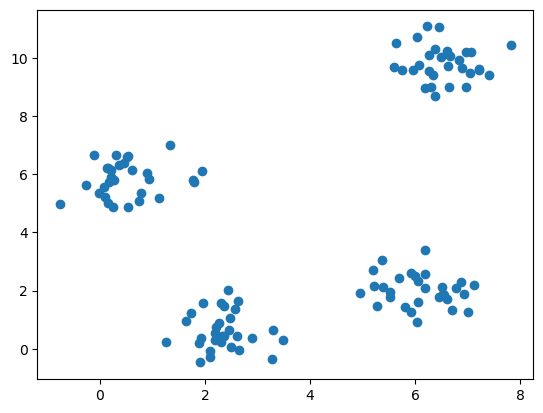

In [39]:
unhash_image(example['img_b64'])

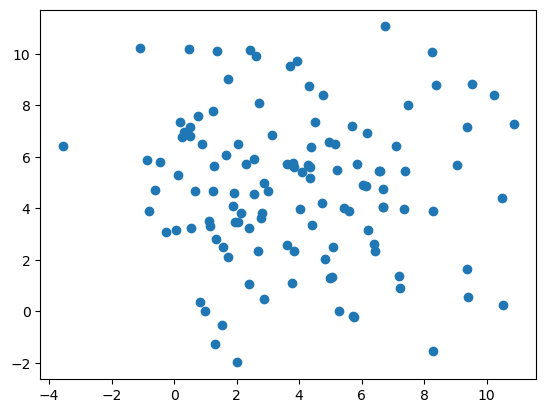

In [40]:
unhash_image(example['img_deceptive'])